In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/si699-music-tagging/

In [ ]:
# %%python3 preprocessing/convert_npy.py

In [1]:
import os
import random
import torch
import librosa
import numpy as np
import glob
import torchaudio
from sklearn.preprocessing import LabelBinarizer
import csv
from transformers import AutoConfig, AutoFeatureExtractor, Wav2Vec2FeatureExtractor
from sklearn.metrics import *
from run.models import *
import collections
import torch
import yaml
import json
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from transformers import BertModel, BertTokenizer
# from transformers import ASTForAudioClassification, Wav2Vec2Processor, AutoConfig
from transformers.models.wav2vec2.modeling_wav2vec2 import (
    Wav2Vec2PreTrainedModel,
    Wav2Vec2Model
)
import logging
from torch.utils.tensorboard import SummaryWriter
from torchmetrics.functional.classification import multilabel_auroc
from torchmetrics.classification import MultilabelPrecision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)
torch.manual_seed(config['seed'])
random.seed(config['seed'])
print("Run on:", device)

/home/lyuxiao/.local/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/lyuxiao/.local/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator12recordStreamERKNS_7DataPtrENS0_10CUDAStreamE
  warn(f"Failed to load image Python extension: {e}")


Run on: cpu


In [2]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, tracks_dict, npy_root, config, tags, data_type, feature_extractor_type):
        self.npy_root = npy_root
        self.config = config
        self.tracks_dict = tracks_dict
        self.tags = tags
        self.mlb = LabelBinarizer().fit(self.tags)
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.title_dict = {}
        self.prepare_title()
        self.data = []
        self.input_ids = []
        self.attention_mask = []
        self.labels = []
        self.data_type = data_type
        self.prepare_data()
        self.feature_extractor_type = feature_extractor_type

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        assert 0 <= index < len(self)
        waveform = self.data[index]
        input_ids = self.input_ids[index]
        attention_mask = self.attention_mask[index]
        target = self.labels[index]
        if self.feature_extractor_type == 'raw':
            mel_spec = torch.Tensor(waveform)
        if self.feature_extractor_type == 'ast':
            feature_extractor = AutoFeatureExtractor.from_pretrained(
                "MIT/ast-finetuned-audioset-10-10-0.4593",
                sampling_rate=self.config['sample_rate'],
                num_mel_bins=self.config['n_mels']
            )
            encoding = feature_extractor(waveform, sampling_rate=self.config['sample_rate'], annotations=target, return_tensors="pt")
            mel_spec = encoding['input_values'].squeeze()
            mel_spec = torch.transpose(mel_spec, 0, 1)
        if self.feature_extractor_type == 'wav2vec':
            feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(
                "facebook/wav2vec2-base-960h"
            )
            encoding = feature_extractor(waveform, sampling_rate=self.config['sample_rate'],
                                         return_tensors="pt")
            mel_spec = encoding['input_values'].squeeze()
        return mel_spec, input_ids, attention_mask, target
    
    def prepare_title(self):
        whole_filenames = sorted(glob.glob(os.path.join(self.npy_root, "*/*.npy")))
        titles = []
        for filename in whole_filenames:
            file_id = os.path.join(filename.split('/')[-2], filename.split('/')[-1].split('.')[0])
            titles.append(self.tracks_dict[file_id][1])
        encoding = self.tokenizer(titles, return_tensors='pt', padding=True, truncation=True)
        input_ids = encoding['input_ids']
        attention_mask = encoding['attention_mask']
        for idx, filename in enumerate(whole_filenames):
            file_id = os.path.join(filename.split('/')[-2], filename.split('/')[-1].split('.')[0])
            self.title_dict[file_id] = (input_ids[idx], attention_mask[idx])
        
    def prepare_data(self):
        whole_filenames = sorted(glob.glob(os.path.join(self.npy_root, "*/*.npy")))
        train_size = int(len(whole_filenames) * 0.8)
        filenames = []
        random.shuffle(whole_filenames)
        if self.data_type == 'train':
            filenames = whole_filenames[:train_size]
        if self.data_type == 'valid':
            filenames = whole_filenames[train_size:]
        for filename in tqdm(filenames):
            file_id = os.path.join(filename.split('/')[-2], filename.split('/')[-1].split('.')[0])
            if file_id not in self.tracks_dict:
                print(file_id)
                continue
            self.data.append(np.load(filename))
            self.input_ids.append(self.title_dict[file_id][0])
            self.attention_mask.append(self.title_dict[file_id][1])
            self.labels.append(np.sum(self.mlb.transform(self.tracks_dict[file_id][0]), axis=0))

In [3]:
def get_tags(tag_file, npy_root, isMap):
    id2title_dict = {}
    with open('data/raw.meta.tsv') as fp:
        reader = csv.reader(fp, delimiter='\t')
        next(reader, None)
        for row in reader:
            id2title_dict[row[0]] = row[3]

    if isMap:
        f = open('tag_categorize.json')
        data = json.load(f)
        categorize = {}
        for k, v in data.items():
            for i in v[1:-1].split(', '):
                categorize[i] = k
    tracks = {}
    total_tags = []
    with open(tag_file) as fp:
        reader = csv.reader(fp, delimiter='\t')
        next(reader, None)  # skip header
        for row in reader:
            if not os.path.exists(os.path.join(npy_root, row[3].replace('.mp3', '.npy'))):
                print(os.path.join(npy_root, row[3].replace('.mp3', '.npy')))
                continue
            track_id = row[3].split('.')[0]
            tags = []
            for tag in row[5:]:
                if isMap:
                    tags.append(categorize[tag.split('---')[-1]])
                else:
                    tags.append(tag.split('---')[-1])
            tracks[track_id] = (list(set(tags)), id2title_dict[row[0]])
            total_tags += list(set(tags))
    print("Distribution of tags:", collections.Counter(total_tags))
    plt.figure(figsize=(10,3))
    plt.xticks(rotation=90)
    plt.hist(total_tags)
    plt.savefig('dist.png')
    return tracks, list(set(total_tags))

Preparing dataset...
Distribution of tags: Counter({'happy': 1657, 'film': 1502, 'energetic': 1357, 'relaxing': 1350, 'emotional': 1271, 'melodic': 1213, 'dark': 1202, 'epic': 982, 'dream': 951, 'love': 909, 'inspiring': 877, 'sad': 749, 'meditative': 742, 'uplifting': 693, 'advertising': 673, 'deep': 635, 'motivational': 635, 'romantic': 627, 'christmas': 623, 'documentary': 612, 'corporate': 609, 'positive': 539, 'summer': 505, 'space': 503, 'background': 496, 'soundscape': 480, 'fun': 480, 'soft': 465, 'ambiental': 460, 'calm': 457, 'children': 456, 'adventure': 448, 'upbeat': 444, 'melancholic': 441, 'slow': 437, 'commercial': 428, 'drama': 424, 'movie': 413, 'action': 407, 'ballad': 334, 'dramatic': 317, 'sport': 297, 'trailer': 270, 'party': 266, 'game': 261, 'nature': 259, 'cool': 251, 'powerful': 238, 'hopeful': 216, 'retro': 213, 'funny': 203, 'groovy': 194, 'holiday': 176, 'travel': 171, 'horror': 158, 'heavy': 156, 'mellow': 154, 'sexy': 122, 'fast': 119})
59


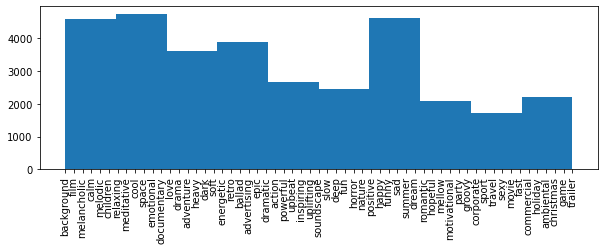

In [4]:
print("Preparing dataset...")
tag_file = 'data/autotagging_moodtheme.tsv'
npy_root = 'data/waveform'
tracks_dict, tags = get_tags(tag_file, npy_root, False)
N_CLASSES = len(tags)
print(N_CLASSES)

In [5]:
transform = 'raw'
batch_size = 4
train_dataset = MyDataset(tracks_dict, npy_root, config, tags, "train", transform)
val_dataset = MyDataset(tracks_dict, npy_root, config, tags, "valid", transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

100%|██████████| 3698/3698 [00:23<00:00, 160.30it/s]


In [6]:
for waveform, input_ids, attention_mask, label in val_loader:
    print(waveform)
    print(input_ids)
    print(attention_mask)
    print(label)
    break

tensor([[ 0.2647, -0.1546, -0.0190,  ...,  0.0558, -0.7055,  0.2956],
        [-0.0667,  0.2654,  0.1454,  ...,  0.1265, -0.0362, -0.0065],
        [-0.0720, -0.0663,  0.0706,  ..., -0.5072, -0.0366,  0.1323],
        [ 0.1688, -0.2995, -0.1785,  ...,  0.3414, -0.2259, -0.1064]])
tensor([[  101,  7484, 21262,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101,  5292,  1043, 19291,  2290,  1011,   100,  1770,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0

In [7]:
def train(model, epoch, criterion, optimizer, train_loader, is_title=False):
    losses = []
    ground_truth = []
    prediction = []
    model.train()
    for waveform, input_ids, attention_mask, label in tqdm(train_loader):
        waveform, label = waveform.to(device), label.to(device)
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
        if is_title:
            output = model(waveform, input_ids, attention_mask)
        else:
            output = model(waveform)
        loss = criterion(output, label.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.cpu().detach())
        ground_truth.append(label)
        prediction.append(output)
    get_eval_metrics(prediction, ground_truth, 'train', epoch, losses)


@torch.no_grad()
def validate(model, epoch, criterion, val_loader, is_title=False):
    losses = []
    ground_truth = []
    prediction = []
    model.eval()
    for waveform, input_ids, attention_mask, label in tqdm(val_loader):
        waveform, label = waveform.to(device), label.to(device)
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
        if is_title:
            output = model(waveform, input_ids, attention_mask)
        else:
            output = model(waveform)
        loss = criterion(output, label.float())
        losses.append(loss.cpu().detach())
        ground_truth.append(label)
        prediction.append(output)
    pre = get_eval_metrics(prediction, ground_truth, 'val', epoch, losses)
    return pre


def get_eval_metrics(outputs, labels, run_type, epoch, losses):
    outputs = torch.cat(outputs, dim=0)
    labels = torch.cat(labels, dim=0)
    assert outputs.shape == labels.shape
    # 1. number of correctly predicted tags divided by the total number of tags
    prob_classes = []
    for i in range(labels.size(0)):
        label = labels[i]
        k = label.sum()
        _, idx = outputs[i].topk(k=k)
        predict = torch.zeros_like(outputs[i])
        predict[idx] = 1
        prob_classes.append(predict)
    prob_classes = torch.stack(prob_classes)
    matched_1s = torch.mul(prob_classes, labels)
    correct_tag_percentage = matched_1s.sum() / labels.sum()

    # 2. Auroc
    auroc = multilabel_auroc(outputs, labels, num_labels=N_CLASSES, average="macro", thresholds=None).item()

    # 3. avg precision
    metric = MultilabelPrecision(average='macro', num_labels=N_CLASSES, thresholds=None).to(device)
    pre = metric(outputs, labels).item()

    # write tensorboard and logging file
    writer.add_scalar("Loss/{}".format(run_type), np.mean(losses), epoch)
    writer.add_scalar("Auroc/{}".format(run_type), auroc, epoch)
    writer.add_scalar("Pre/{}".format(run_type), pre, epoch)
    writer.add_scalar("Avg_percent/{}".format(run_type), correct_tag_percentage, epoch)
    print("{} - epoch: {}, loss: {}, auroc: {}, pre: {}, avg percent: {}".format(
        run_type, epoch, np.mean(losses), auroc, pre, correct_tag_percentage))
    logging.info("{} - epoch: {}, loss: {}, auroc: {}, pre: {}, avg percent: {}".format(
        run_type, epoch, np.mean(losses), auroc, pre, correct_tag_percentage))
    return correct_tag_percentage


def get_model(model_name, tags):
    if model_name =='samplecnn':
        model = SampleCNN(N_CLASSES, config).to(device)
    elif model_name == 'crnn':
        model = CRNN(N_CLASSES, config).to(device)
    elif model_name =='fcn':
        model = FCN(N_CLASSES, config).to(device)
    elif model_name == 'musicnn':
        model = Musicnn(N_CLASSES, config).to(device)
    elif model_name == 'musicnn_title':
        model = MusicnnwithTitle(N_CLASSES, config).to(device)
    elif model_name == 'shortchunkcnn_res':
        model = ShortChunkCNN_Res(N_CLASSES, config).to(device)
    elif model_name == 'cnnsa':
        model = CNNSA(N_CLASSES, config).to(device)
    elif model_name == 'baseline2':
        model = Baseline2(N_CLASSES, config).to(device)
    elif model_name == 'wav2vec':
        model_config = AutoConfig.from_pretrained(
            "facebook/wav2vec2-base-960h",
            num_labels=N_CLASSES,
            label2id={label: i for i, label in enumerate(tags)},
            id2label={i: label for i, label in enumerate(tags)},
            finetuning_task="wav2vec2_clf",
        )
        model = Wav2Vec2ForSpeechClassification(model_config).to(device)
    else:
        model = SampleCNN(N_CLASSES, config).to(device)
    return model

In [8]:
class MusicnnwithTitle(nn.Module):
    def __init__(self, num_classes, config=None):
        super(Musicnn, self).__init__()
        self.spec = torchaudio.transforms.MelSpectrogram(sample_rate=config['sample_rate'],
                                                  n_fft=config['n_fft'],
                                                  f_min=config['fmin'],
                                                  f_max=config['fmax'],
                                                  n_mels=config['n_mels'])

        # Spectrogram
        self.to_db = torchaudio.transforms.AmplitudeToDB()
        self.spec_bn = nn.BatchNorm2d(1)

        # Pons front-end
        m1 = Conv_V(1, 204, (int(0.7 * 96), 7))
        m2 = Conv_V(1, 204, (int(0.4 * 96), 7))
        m3 = Conv_H(1, 51, 129)
        m4 = Conv_H(1, 51, 65)
        m5 = Conv_H(1, 51, 33)
        self.layers = nn.ModuleList([m1, m2, m3, m4, m5])

        # Pons back-end
        backend_channel = 512
        self.layer1 = Conv_1d(561, backend_channel, kernel_size=7, stride=1, padding=3, pooling=1)
        self.layer2 = Conv_1d(backend_channel, backend_channel, kernel_size=7, stride=1, padding=3, pooling=1)
        self.layer3 = Conv_1d(backend_channel, backend_channel, kernel_size=7, stride=1, padding=3, pooling=1)

        # Dense
        dense_channel = 500
        self.dense1 = nn.Linear((561 + (backend_channel * 3)) * 2, dense_channel)
        self.bn = nn.BatchNorm1d(dense_channel)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.dense2 = nn.Linear(dense_channel, num_classes)
        
        self.bert = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dense3 = nn.Linear(self.bert.config.hidden_size, 256)
        self.dense4 = nn.Linear(256, num_classes)
        
        self.dense5 = nn.Linear(2*num_classes, num_classes)
        

    def forward(self, x, input_ids=None, attention_mask=None):
        # Spectrogram
        x = self.spec(x)
        x = self.to_db(x)
        x = x.unsqueeze(1)
        x = self.spec_bn(x)

        # Pons front-end
        out = []
        for layer in self.layers:
            out.append(layer(x))
        out = torch.cat(out, dim=1)

        # Pons back-end
        length = out.size(2)
        res1 = self.layer1(out)
        res2 = self.layer2(res1) + res1
        res3 = self.layer3(res2) + res2
        out = torch.cat([out, res1, res2, res3], 1)

        mp = nn.MaxPool1d(length)(out)
        avgp = nn.AvgPool1d(length)(out)

        out = torch.cat([mp, avgp], dim=1)
        out = out.squeeze(2)

        out = self.relu(self.bn(self.dense1(out)))
        out = self.dropout(out)
        out = self.dense2(out)
        
        out_title = self.bert(input_ids, attention_mask=attention_mask)
        out_title = self.dense3(out_title.pooler_output)
        out_title = self.dropout(out_title)
        out_title = self.dense4(out_title)
        
        out = torch.cat((out_title, out), dim=1)
        out = self.dense5(out)
        out = nn.Sigmoid()(out)
        return out

In [9]:
model_name = 'musicnn_title'
learning_rate = 1e-4
num_epochs = 10
model = get_model(model_name, tags)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
print("Training and validating model...")
writer = SummaryWriter('runs/{}_{}_{}_{}'.format(model_name, learning_rate, batch_size, len(tags)))
logging.basicConfig(filename="log/log_{}_{}_{}_{}".format(model_name, learning_rate, batch_size, len(tags)),
                    format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                    datefmt='%H:%M:%S',
                    level=logging.INFO)
best_pre = float('-inf')
for epoch in range(num_epochs):
    train(model, epoch, criterion, optimizer, train_loader, True)
    pre = validate(model, epoch, criterion, val_loader, True)
    if pre > best_pre:
        print("Best avg precision:", pre)
        best_pre = pre
        torch.save(model.state_dict(), 'model/{}_best_score_{}_{}.pt'.format(model_name, learning_rate, len(tags)))

/home/lyuxiao/.local/lib/python3.9/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to 

Training and validating model...


100%|██████████| 3697/3697 [07:39<00:00,  8.05it/s]


train - epoch: 0, loss: 0.07646988332271576, auroc: 0.9861521124839783, pre: 0.8669588565826416, avg percent: 0.8885020613670349


100%|██████████| 925/925 [00:33<00:00, 27.33it/s]


val - epoch: 0, loss: 0.25514987111091614, auroc: 0.8951526880264282, pre: 0.6540236473083496, avg percent: 0.673331081867218
Best avg precision: tensor(0.6733, device='cuda:0')


100%|██████████| 3697/3697 [06:58<00:00,  8.84it/s]


train - epoch: 1, loss: 0.06391412019729614, auroc: 0.9908768534660339, pre: 0.8906944990158081, avg percent: 0.9169921875


100%|██████████| 925/925 [00:34<00:00, 27.13it/s]


val - epoch: 1, loss: 0.2741473615169525, auroc: 0.8943119049072266, pre: 0.689926266670227, avg percent: 0.668078601360321


100%|██████████| 3697/3697 [07:00<00:00,  8.79it/s]


train - epoch: 2, loss: 0.06071602925658226, auroc: 0.9917463064193726, pre: 0.9000226259231567, avg percent: 0.92357337474823


100%|██████████| 925/925 [00:34<00:00, 27.15it/s]


val - epoch: 2, loss: 0.27402856945991516, auroc: 0.8970816135406494, pre: 0.677152156829834, avg percent: 0.6685869097709656


100%|██████████| 3697/3697 [06:40<00:00,  9.22it/s]


train - epoch: 3, loss: 0.05837182328104973, auroc: 0.9925333857536316, pre: 0.9025216102600098, avg percent: 0.9270550012588501


100%|██████████| 925/925 [00:32<00:00, 28.62it/s]


val - epoch: 3, loss: 0.27218177914619446, auroc: 0.8983380198478699, pre: 0.6699137687683105, avg percent: 0.6785835027694702
Best avg precision: tensor(0.6786, device='cuda:0')


100%|██████████| 3697/3697 [06:39<00:00,  9.25it/s]


train - epoch: 4, loss: 0.05657251551747322, auroc: 0.9929123520851135, pre: 0.9063295125961304, avg percent: 0.93215012550354


100%|██████████| 925/925 [00:32<00:00, 28.76it/s]


val - epoch: 4, loss: 0.26015374064445496, auroc: 0.9006295204162598, pre: 0.6780236959457397, avg percent: 0.691629946231842
Best avg precision: tensor(0.6916, device='cuda:0')


100%|██████████| 3697/3697 [06:38<00:00,  9.27it/s]


train - epoch: 5, loss: 0.056826744228601456, auroc: 0.9928158521652222, pre: 0.904435396194458, avg percent: 0.93019700050354


100%|██████████| 925/925 [00:32<00:00, 28.89it/s]


val - epoch: 5, loss: 0.27713048458099365, auroc: 0.9002503752708435, pre: 0.6623246073722839, avg percent: 0.672653317451477


100%|██████████| 3697/3697 [06:39<00:00,  9.26it/s]


train - epoch: 6, loss: 0.05515450984239578, auroc: 0.9932425022125244, pre: 0.9089646339416504, avg percent: 0.9345703125


100%|██████████| 925/925 [00:32<00:00, 28.86it/s]


val - epoch: 6, loss: 0.27062129974365234, auroc: 0.899032711982727, pre: 0.6762994527816772, avg percent: 0.6928160190582275
Best avg precision: tensor(0.6928, device='cuda:0')


100%|██████████| 3697/3697 [06:38<00:00,  9.27it/s]


train - epoch: 7, loss: 0.0534624420106411, auroc: 0.9937862753868103, pre: 0.911787748336792, avg percent: 0.93898606300354


100%|██████████| 925/925 [00:32<00:00, 28.77it/s]


val - epoch: 7, loss: 0.2738068699836731, auroc: 0.902097761631012, pre: 0.6846397519111633, avg percent: 0.6809555888175964


100%|██████████| 3697/3697 [06:39<00:00,  9.26it/s]


train - epoch: 8, loss: 0.05278297886252403, auroc: 0.9939206838607788, pre: 0.912427544593811, avg percent: 0.93800950050354


100%|██████████| 925/925 [00:32<00:00, 28.86it/s]


val - epoch: 8, loss: 0.2737002670764923, auroc: 0.901712954044342, pre: 0.6894341707229614, avg percent: 0.6858692169189453


  2%|▏         | 64/3697 [00:07<06:41,  9.06it/s]


KeyboardInterrupt: 

In [8]:
def baseline1(tag_file, npy_root, batch_size, isMap, val_loader, tags):
    whole_filenames = sorted(glob.glob(os.path.join(npy_root, "*/*.npy")))
    train_size = int(len(whole_filenames) * 0.8)
    # val_size = int(len(whole_filenames) * 0.95)
    filenames = []
    random.shuffle(whole_filenames)
    train_filenames = whole_filenames[:train_size]
    train_ids = []
    for filename in train_filenames:
        train_ids.append(filename.split('/')[-2] + '/' + filename.split('/')[-1])
    if isMap:
        f = open('tag_categorize.json')
        data = json.load(f)
        categorize = {}
        for k, v in data.items():
            for i in v[1:-1].split(', '):
                categorize[i] = k
    train_total_tags = []
    with open(tag_file) as fp:
        reader = csv.reader(fp, delimiter='\t')
        next(reader, None)  # skip header
        for row in reader:
            if row[3].replace('.mp3', '.npy') not in train_ids:
                # if not in train set
                continue
            if not os.path.exists(os.path.join(npy_root, row[3].replace('.mp3', '.npy'))):
                print(os.path.join(npy_root, row[3].replace('.mp3', '.npy')))
                continue
            tmp = []
            for tag in row[5:]:
                if isMap:
                    tmp.append(categorize[tag.split('---')[-1]])
                else:
                    tmp.append(tag.split('---')[-1])
            train_total_tags += list(set(tmp))

    train_dist_tags = collections.Counter(train_total_tags)
    print(train_dist_tags)
    total = 0
    for v in train_dist_tags.values():
        total += v
    probs = []
    for t in tags:
        probs.append(train_dist_tags[t]/total)
    labels, outputs = [], []
    for _, _, _, label in val_loader:  
        labels.append(label)
        for _ in range(label.size(0)):
            outputs.append(probs)
    
    outputs = torch.Tensor(outputs)
    labels = torch.cat(labels, dim=0)
    print(outputs.shape)
    assert outputs.shape == labels.shape, "{}, {}".format(outputs.shape, labels.shape)
    # 1. number of correctly predicted tags divided by the total number of tags
    prob_classes = []
    for i in range(labels.size(0)):
        label = labels[i]
        k = label.sum()
        _, idx = outputs[i].topk(k=k)
        predict = torch.zeros_like(outputs[i])
        predict[idx] = 1
        # print(k, predict)
        prob_classes.append(predict)
    prob_classes = torch.stack(prob_classes)
    matched_1s = torch.mul(prob_classes, labels)
    correct_tag_percentage = matched_1s.sum() / labels.sum()

    # 2. Auroc
    auroc = multilabel_auroc(outputs, labels, num_labels=N_CLASSES, average="macro", thresholds=None).item()

    # 3. avg precision
    metric = MultilabelPrecision(average='macro', num_labels=N_CLASSES, thresholds=None).to(device)
    pre = metric(outputs, labels).item()

    print("auroc: {}, pre: {}, avg percent: {}".format(auroc, pre, correct_tag_percentage))
baseline1(tag_file, npy_root, batch_size, False, val_loader, tags)

Counter({'happy': 1340, 'film': 1199, 'relaxing': 1091, 'energetic': 1055, 'emotional': 1035, 'melodic': 965, 'dark': 957, 'epic': 799, 'dream': 750, 'love': 736, 'inspiring': 710, 'sad': 611, 'meditative': 598, 'uplifting': 558, 'advertising': 557, 'deep': 532, 'motivational': 512, 'romantic': 504, 'christmas': 500, 'documentary': 486, 'corporate': 482, 'positive': 422, 'summer': 414, 'space': 406, 'background': 388, 'soundscape': 388, 'soft': 371, 'calm': 369, 'children': 367, 'adventure': 366, 'fun': 366, 'upbeat': 361, 'ambiental': 361, 'melancholic': 358, 'drama': 346, 'slow': 345, 'commercial': 344, 'movie': 329, 'action': 325, 'ballad': 258, 'dramatic': 257, 'sport': 237, 'trailer': 223, 'party': 222, 'nature': 216, 'game': 215, 'cool': 202, 'powerful': 189, 'groovy': 167, 'hopeful': 165, 'funny': 162, 'retro': 161, 'holiday': 140, 'travel': 131, 'mellow': 125, 'horror': 121, 'heavy': 113, 'sexy': 97, 'fast': 92})
torch.Size([3698, 59])
auroc: 0.5, pre: 0.0, avg percent: 0.04998